### 一、Linear Module

Linear 模块也被成为全连接层  
- 数学本质：$y=Wx+b$ ,X为输入向量，W为权重矩阵，b为偏置  
- 物理意义：负责将输入特征从一个特征空间投影到另一个特征空间。比如在FNN中，先将维度扩大，再缩小回来，提取深层语义  
- 目前B项普遍取消

### 二、计算成本  
#### 2.1 计算量（FLOPS）  
- 前向传播规则:对于一个$M\times N$的输入矩阵X，和一个$N\times k$的权重矩阵W，计算量大约是$2\times M\times N\times k$  
- 训练全过程：一次前向和一次后向传播的计算量为 $6\times 参数量\times Token$  
  
#### 2.2 显存占用  
- 单参数成本：如果使用AdamW优化器，每个线性层的参数实际上需要16字节的显存空间  
- 精度选择：BF16或者FP16  

#### 2.3 初始化  
- 如果线性层的权重W随机给的数字太大，输出结果会随着网络深度呈现指数级爆炸；如果太小，则会消失  
- 黄金标准：Xavier初始化或kaiming初始化。核心思想是让权重的方差与输入维度的平方根成反比，即$W\sim \mathcal{N}(0,\frac{1}{\sqrt{N}})$。确保信号平稳

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
#中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

In [10]:
#初始化linear
linear=nn.Linear(in_features=4,out_features=2,bias=True)
print(linear)


Linear(in_features=4, out_features=2, bias=True)


In [11]:
#查看可训练参数
weight_w=linear.weight.data
bias_b=linear.bias.data
print(f"权重参数：\n{weight_w}\n形状：{weight_w.shape}")
print(f"偏置参数：\n{bias_b}\n形状：{bias_b.shape}")

权重参数：
tensor([[ 0.3057, -0.2840,  0.4890,  0.1595],
        [-0.3793, -0.2403,  0.0518, -0.2116]])
形状：torch.Size([2, 4])
偏置参数：
tensor([-0.2931, -0.1480])
形状：torch.Size([2])


In [12]:
#单样本输入
single_idx=torch.FloatTensor([[1.0,2.0,3.0,4.0]])
#前向传播
single_y=linear(single_idx)
print(f"单样本输入：{single_idx}\n输出结果：{single_y}")

单样本输入：tensor([[1., 2., 3., 4.]])
输出结果：tensor([[ 1.5497, -1.6989]], grad_fn=<AddmmBackward0>)


In [13]:
#批量样本
batch_idx=torch.FloatTensor([[1.0,2.0,3.0,4.0],
                              [4.0,3.0,2.0,1.0],
                              [5.0,6.0,7.0,8.0]])
batch_y=linear(batch_idx)
print(f"批量样本输入：\n{batch_idx}\n输出结果：\n{batch_y}")

批量样本输入：
tensor([[1., 2., 3., 4.],
        [4., 3., 2., 1.],
        [5., 6., 7., 8.]])
输出结果：
tensor([[ 1.5497, -1.6989],
        [ 1.2155, -2.4942],
        [ 4.2308, -4.8166]], grad_fn=<AddmmBackward0>)


In [14]:
#线性变换
manual_w_T=weight_w.transpose(0,1)
manual_single_y=torch.matmul(single_idx,manual_w_T)+bias_b
print(f"手动计算单样本输出：{manual_single_y}")
print(f'Linear层单样本输出：{single_y}')
print(f"两者是否相等：{torch.allclose(manual_single_y,single_y)}")

manual_batch_y=torch.matmul(batch_idx,manual_w_T)+bias_b
print(f"手动计算批量样本输出：\n{manual_batch_y}")
print(f'Linear层批量样本输出：\n{batch_y}')
print(f"两者是否相等：{torch.allclose(manual_batch_y,batch_y)}")


手动计算单样本输出：tensor([[ 1.5497, -1.6989]])
Linear层单样本输出：tensor([[ 1.5497, -1.6989]], grad_fn=<AddmmBackward0>)
两者是否相等：True
手动计算批量样本输出：
tensor([[ 1.5497, -1.6989],
        [ 1.2155, -2.4942],
        [ 4.2308, -4.8166]])
Linear层批量样本输出：
tensor([[ 1.5497, -1.6989],
        [ 1.2155, -2.4942],
        [ 4.2308, -4.8166]], grad_fn=<AddmmBackward0>)
两者是否相等：True


In [15]:
#无偏置线性变换
linear_nobias=nn.Linear(in_features=4,out_features=2,bias=False)
weight_w_nobias=linear_nobias.weight.data
single_y_nobias=linear_nobias(single_idx)
manual_single_y_nobias=torch.matmul(single_idx,weight_w_nobias.transpose(0,1))
print(f"无偏置线性变换单样本输出是否相等：{torch.allclose(single_y_nobias,manual_single_y_nobias)}")


无偏置线性变换单样本输出是否相等：True


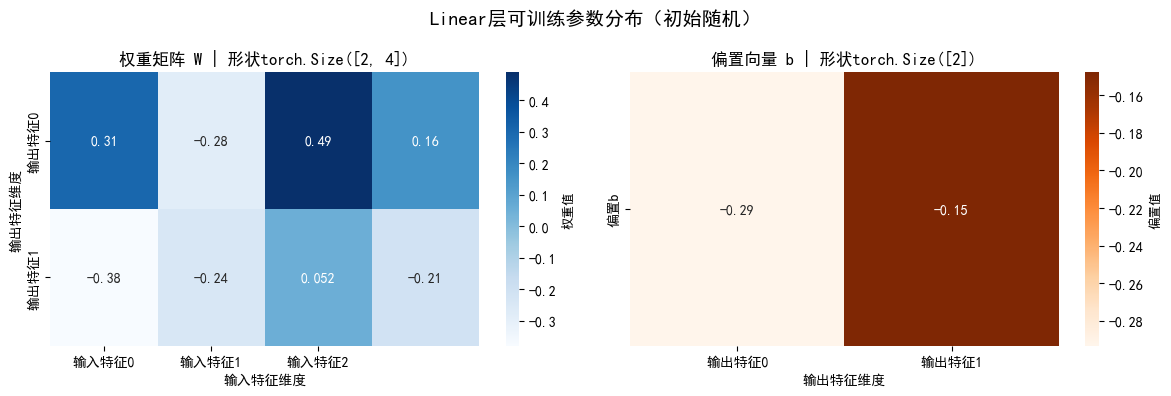

In [16]:
# 可视化权重矩阵和偏置向量
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Linear层可训练参数分布（初始随机）', fontsize=14, fontweight='bold')

# 权重矩阵W热力图 [2,3]
sns.heatmap(weight_w.numpy().round(4), annot=True, cmap='Blues', ax=ax1,
            xticklabels=[f'输入特征{i}' for i in range(3)],
            yticklabels=[f'输出特征{i}' for i in range(2)])
ax1.set_title(f'权重矩阵 W | 形状{weight_w.shape}', fontsize=12)
ax1.set_xlabel('输入特征维度', fontsize=10)
ax1.set_ylabel('输出特征维度', fontsize=10)
# 兼容低版本seaborn设置颜色条标签
ax1.collections[0].colorbar.set_label('权重值', fontsize=9)

# 偏置向量b热力图（转为[1,2]方便可视化）
sns.heatmap(bias_b.unsqueeze(0).numpy().round(4), annot=True, cmap='Oranges', ax=ax2,
            xticklabels=[f'输出特征{i}' for i in range(2)],
            yticklabels=['偏置b'])
ax2.set_title(f'偏置向量 b | 形状{bias_b.shape}', fontsize=12)
ax2.set_xlabel('输出特征维度', fontsize=10)
ax2.set_ylabel('')
ax2.collections[0].colorbar.set_label('偏置值', fontsize=9)

plt.tight_layout()
plt.show()

可视化结果解读
- 左图：权重矩阵 W 的 2 行 3 列数值，每一行对应 1 个输出特征对所有输入特征的权重（如输出特征 0 由输入特征 0/1/2 分别加权后求和得到）；
- 右图：偏置向量 b 的 2 个数值，每个值对应 1 个输出特征的偏移量，用于调整输出的基线，避免线性变换过拟合原点；
- 初始状态为随机分布，训练后权重会向 “拟合任务特征” 的方向更新，偏置也会同步调整。

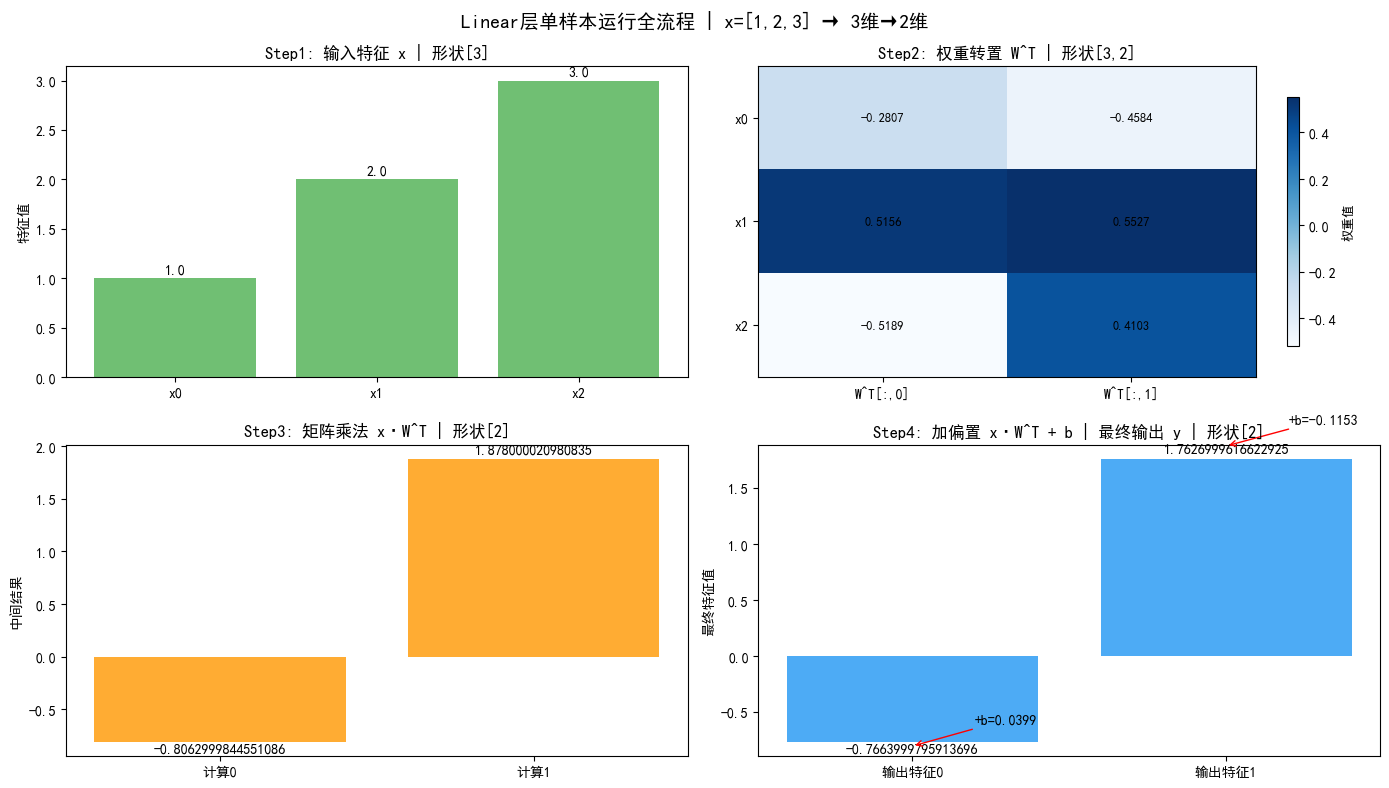

Linear层直接输出：[-0.7664  1.7627]
可视化手动计算输出：[-0.7664  1.7627]
两者是否一致：True


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
linear = nn.Linear(in_features=3, out_features=2, bias=True)
# 可训练参数
weight_W = linear.weight.data.detach()  # 分离计算图+转numpy
bias_b = linear.bias.data.detach()      # 分离计算图+转numpy
# 定义单样本输入
single_x = torch.FloatTensor([1.0, 2.0, 3.0])  # 形状[3]
x = single_x.numpy()
# 带grad的权重/偏置，detach()后转numpy
W = weight_W.numpy()
b = bias_b.numpy()
W_T = W.T             # [3,2]，权重转置
matmul_res = np.dot(x, W_T)  # [3]×[3,2] = [2]
final_res = matmul_res + b   # [2]+[2] = [2]

# 绘制分步计算图
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Linear层单样本运行全流程 | x=[1,2,3] → 3维→2维', fontsize=14, fontweight='bold')
axes = axes.flatten()

# 子图1：输入特征
axes[0].bar(range(3), x, color='#4CAF50', alpha=0.8)
axes[0].set_title('Step1: 输入特征 x | 形状[3]', fontsize=12)
axes[0].set_xticks(range(3))
axes[0].set_xticklabels([f'x{i}' for i in range(3)])
axes[0].set_ylabel('特征值')
for i, v in enumerate(x):
    axes[0].text(i, v+0.05, f'{v}', ha='center', fontsize=10)

# 子图2：权重转置W^T
im2 = axes[1].imshow(W_T.round(4), cmap='Blues', aspect='auto')
axes[1].set_title('Step2: 权重转置 W^T | 形状[3,2]', fontsize=12)
axes[1].set_xticks(range(2))
axes[1].set_xticklabels([f'W^T[:,{i}]' for i in range(2)])
axes[1].set_yticks(range(3))
axes[1].set_yticklabels([f'x{i}' for i in range(3)])
# 标注数值
for i in range(3):
    for j in range(2):
        axes[1].text(j, i, f'{W_T[i,j]:.4f}', ha='center', va='center', fontsize=9)
plt.colorbar(im2, ax=axes[1], shrink=0.8).set_label('权重值', fontsize=9)

# 子图3：矩阵乘法结果 x·W^T
axes[2].bar(range(2), matmul_res.round(4), color='#FF9800', alpha=0.8)
axes[2].set_title('Step3: 矩阵乘法 x·W^T | 形状[2]', fontsize=12)
axes[2].set_xticks(range(2))
axes[2].set_xticklabels([f'计算{i}' for i in range(2)])
axes[2].set_ylabel('中间结果')
for i, v in enumerate(matmul_res.round(4)):
    axes[2].text(i, v+0.05 if v>=0 else v-0.1, f'{v}', ha='center', fontsize=10)

# 子图4：加偏置最终输出 y
axes[3].bar(range(2), final_res.round(4), color='#2196F3', alpha=0.8)
axes[3].set_title('Step4: 加偏置 x·W^T + b | 最终输出 y | 形状[2]', fontsize=12)
axes[3].set_xticks(range(2))
axes[3].set_xticklabels([f'输出特征{i}' for i in range(2)])
axes[3].set_ylabel('最终特征值')
for i, v in enumerate(final_res.round(4)):
    axes[3].text(i, v+0.05 if v>=0 else v-0.1, f'{v}', ha='center', fontsize=10)
    # 标注偏置添加过程
    axes[3].annotate(f'+b={b[i]:.4f}', xy=(i, matmul_res[i].round(4)),
                     xytext=(i+0.2, matmul_res[i].round(4)+0.2),
                     arrowprops=dict(arrowstyle='->', color='red', lw=1))

plt.tight_layout()
plt.show()

# 验证：手动计算与Linear层输出是否一致
linear_output = linear(single_x).detach().numpy()
print(f"Linear层直接输出：{linear_output.round(4)}")
print(f"可视化手动计算输出：{final_res.round(4)}")
print(f"两者是否一致：{np.allclose(linear_output, final_res, atol=1e-4)}")

可视化结果解读
- 将抽象的线性变换拆解为4 个直观步骤，每个步骤标注形状和数值：
- 输入特征：3 个浮点数值，对应 3 维输入特征；
- 权重转置：将原始 [2,3] 的权重转为 [3,2]，为矩阵乘法做维度匹配；
- 矩阵乘法：输入特征与转置后权重做点积，得到 2 维中间结果（无偏置的线性变换）；
- 加偏置：将偏置向量的 2 个值分别加到中间结果的对应位置，得到最终 2 维输出特征（红色箭头标注偏置的添加过程）。

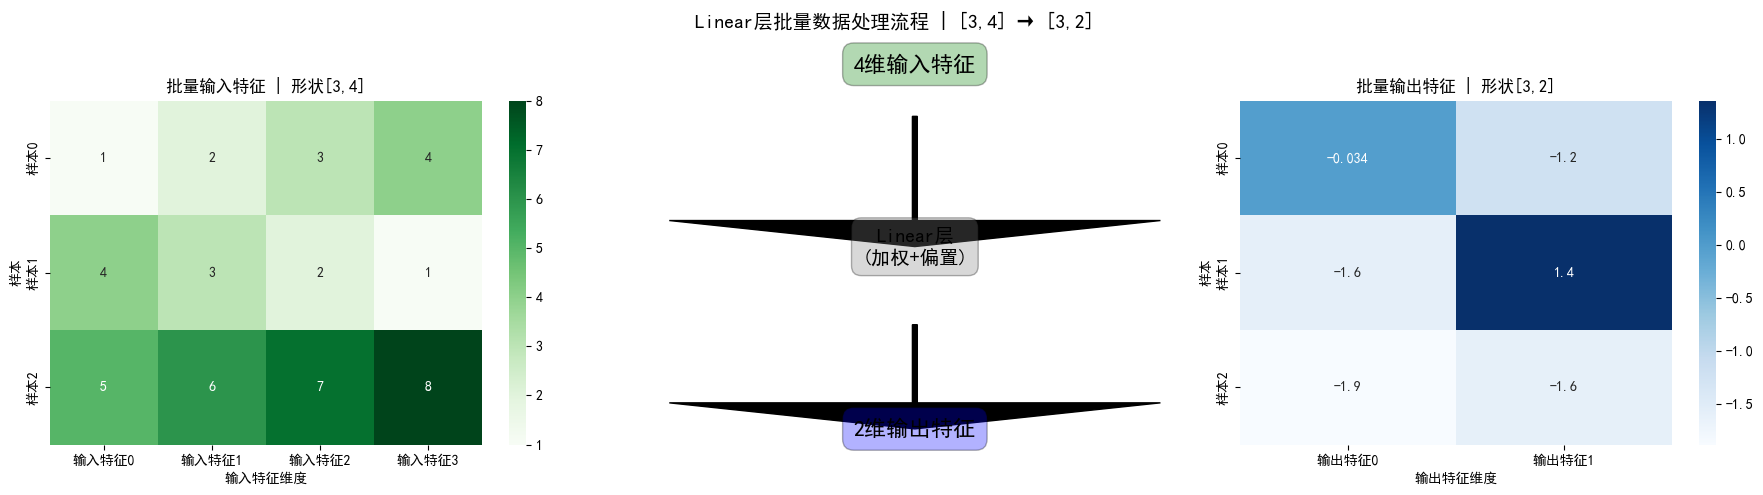

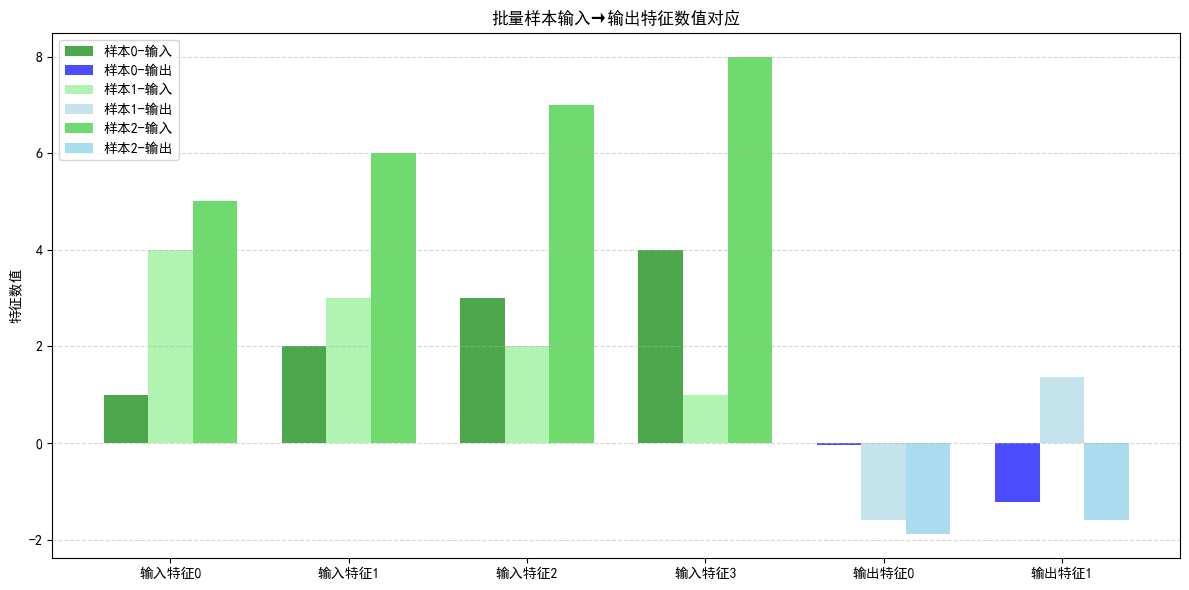

输入形状：(3, 4) → 输出形状：(3, 2)
批量输出特征（保留4位小数）：
 [[-0.0341 -1.2243]
 [-1.5876  1.3578]
 [-1.8843 -1.5991]]


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

linear = nn.Linear(in_features=4, out_features=2, bias=True)

batch_x = torch.FloatTensor([[1.0, 2.0, 3.0, 4.0],
                             [4.0, 3.0, 2.0, 1.0],
                             [5.0, 6.0, 7.0, 8.0]])  # 形状[3,4]：3样本，每个4维特征


batch_y = linear(batch_x)  # 生成批量输出，形状[3,2]（带grad，不可直接转numpy）

batch_x_np = batch_x.numpy()  # 输入无grad，可直接转换
batch_y_np = batch_y.detach().numpy()  # 输出有grad，必须detach()后转换


sample_names = ['样本0', '样本1', '样本2']  # 3个样本，对应batch_x的第一维
input_feat_names = [f'输入特征{i}' for i in range(4)]  # 4维输入，对应batch_x的最后一维
output_feat_names = [f'输出特征{i}' for i in range(2)]  # 2维输出，对应batch_y的最后一维


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Linear层批量数据处理流程 | [3,4] → [3,2]', fontsize=14, fontweight='bold')

# 子图1：批量输入特征热力图 [3,4]
sns.heatmap(batch_x_np, annot=True, cmap='Greens', ax=ax1,
            xticklabels=input_feat_names, yticklabels=sample_names)
ax1.set_title('批量输入特征 | 形状[3,4]', fontsize=12)
ax1.set_xlabel('输入特征维度', fontsize=10)
ax1.set_ylabel('样本', fontsize=10)

# 子图2：维度映射示意（4维→2维）
ax2.axis('off')
ax2.text(0.5, 0.7, '4维输入特征', ha='center', va='center', fontsize=16,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='green', alpha=0.3))
ax2.arrow(0.5, 0.6, 0, -0.2, head_width=0.1, head_length=0.05, fc='black', ec='black')
ax2.text(0.5, 0.35, 'Linear层\n(加权+偏置)', ha='center', va='center', fontsize=14,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='gray', alpha=0.3))
ax2.arrow(0.5, 0.2, 0, -0.15, head_width=0.1, head_length=0.05, fc='black', ec='black')
ax2.text(0.5, 0.0, '2维输出特征', ha='center', va='center', fontsize=16,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='blue', alpha=0.3))

# 子图3：批量输出特征热力图 [3,2]
sns.heatmap(batch_y_np.round(4), annot=True, cmap='Blues', ax=ax3,
            xticklabels=output_feat_names, yticklabels=sample_names)
ax3.set_title('批量输出特征 | 形状[3,2]', fontsize=12)
ax3.set_xlabel('输出特征维度', fontsize=10)
ax3.set_ylabel('样本', fontsize=10)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# 生成刻度位置，适配4个输入特征+2个输出特征
x_ticks = np.arange(len(input_feat_names + output_feat_names))
# 绘制3个样本的输入+输出特征（宽度0.25，避免重叠）
width = 0.25
ax.bar(x_ticks[:4], batch_x_np[0], width, label='样本0-输入', color='green', alpha=0.7)
ax.bar(x_ticks[4:], batch_y_np[0], width, label='样本0-输出', color='blue', alpha=0.7)
ax.bar(x_ticks[:4]+width, batch_x_np[1], width, label='样本1-输入', color='lightgreen', alpha=0.7)
ax.bar(x_ticks[4:]+width, batch_y_np[1], width, label='样本1-输出', color='lightblue', alpha=0.7)
ax.bar(x_ticks[:4]+2*width, batch_x_np[2], width, label='样本2-输入', color='limegreen', alpha=0.7)
ax.bar(x_ticks[4:]+2*width, batch_y_np[2], width, label='样本2-输出', color='skyblue', alpha=0.7)

# 图表样式设置
ax.set_title('批量样本输入→输出特征数值对应', fontsize=12)
ax.set_xticks(x_ticks + width)  # 刻度居中
ax.set_xticklabels(input_feat_names + output_feat_names, rotation=0)
ax.set_ylabel('特征数值')
ax.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"输入形状：{batch_x_np.shape} → 输出形状：{batch_y_np.shape}")
print("批量输出特征（保留4位小数）：\n", batch_y_np.round(4))

可视化结果解读：
- 批量处理核心特性：逐样本独立执行线性变换，样本 0 的输入仅生成样本 0 的输出，样本 1 同理，批量之间互不干扰；
- 维度映射：无论批量大小是多少，Linear 层仅改变最后一维的特征维度（3→2），批量维度（2）始终保持不变；
- 计算效率：PyTorch 底层采用向量化矩阵乘法处理批量数据，而非循环逐样本计算，大幅提升 GPU/CPU 的计算效率；
- 数值对应：两个样本的输入特征不同，经过相同的权重和偏置变换后，输出特征也不同，体现了 Linear 层对特征的 “加权映射” 作用